# Visualization and Exploration of OCO-2 SIF Lite data
---

In [1]:
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import cartopy.crs as ccrs
import cartopy

In [29]:
# Colormap
from palettable.scientific.sequential import Oleron_10
cm = Oleron_10.mpl_colormap
# mapping to center the colormap at 0
offset = colors.TwoSlopeNorm(vcenter=0, vmin=-0.5, vmax=1.4)

NOTES:
- can files be opened from opendap link (see txt file in HPC dir)
- will ultimately need apply quality flags to mask some negative values

## What's in a single file?

In [245]:
# Notice that netcdf groups are ignored
filename = "../data/OCO2_SIF_Lite/2014/oco2_LtSIF_140906_B10206r_200730212646s.nc4"

ds = xarray.open_dataset(filename)    
ds

<xarray.Dataset>
Dimensions:                (sounding_dim: 176422, vertex_dim: 4)
Dimensions without coordinates: sounding_dim, vertex_dim
Data variables:
    Delta_Time             (sounding_dim) datetime64[ns] ...
    SZA                    (sounding_dim) float32 ...
    VZA                    (sounding_dim) float32 ...
    SAz                    (sounding_dim) float32 ...
    VAz                    (sounding_dim) float32 ...
    Longitude              (sounding_dim) float32 ...
    Latitude               (sounding_dim) float32 ...
    Longitude_Corners      (sounding_dim, vertex_dim) float32 ...
    Latitude_Corners       (sounding_dim, vertex_dim) float32 ...
    SIF_740nm              (sounding_dim) float32 ...
    SIF_Uncertainty_740nm  (sounding_dim) float32 ...
    Daily_SIF_740nm        (sounding_dim) float32 ...
    Daily_SIF_757nm        (sounding_dim) float32 ...
    Daily_SIF_771nm        (sounding_dim) float32 ...
    Quality_Flag           (sounding_dim) float32 ...
Attributes:
    References:                        ['Sun, Y. et al., Remote Sensing of En...
    conventions:                       CF-1.6
    product_version:                   B10206r
    summary:                           Fraunhofer-line based SIF retrievals
    keywords:                          ISS, OCO-2, Solar Induced Fluorescence...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    cdm_data:                          point
    comment:                           These data were produced at JPL/Caltech
    date_created:                      2020-07-30T21:26:46Z
    author_name:                       Jet Propulsion Laboratory/Caltech, Chr...
    author_email:                      Christian.Frankenberg@jpl.nasa.gov
    secondary_author_name:             Jet Propulsion Laboratory/Caltech, tho...
    secondary_author_email:            thomas.kurosu@jpl.nasa.gov
    project:                           OCO-2 NASA/JPL
    geospatial_lat_min:                -90.0
    geospatial_lat_max:                90.0
    geospatial_lat_units:              degrees_north
    geospatial_lon_min:                -180.0
    geospatial_lon_max:                180.0
    geospatial_lon_units:              degrees_east
    platform:                          OCO-2 Satellite Spacecraft
    sensor:                            OCO-2 NASA/JPL
    spatial_resolution:                2.1km x 1.3km at nadir (along-track x ...
    date_time_coverage:                ['2014-09-06T01:47:00.894907Z', '2014-...
    day_of_year_coverage:              ['2014-249T01:47:00.894907Z', '2014-24...
    InputCollectionLabel:              Ops_B10003_r02
    InputBuildId:                      B10.0.03
    InputPointers:                     oco2_L2MetND_00958a_140906_B10003r_191...
    CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention
    identifier_product_doi_authority:  http://dx.doi.org/
    identifier_product_doi:            10.5067/XO2LBBNPO010

## Plot a day of SIF retrievals

In [3]:
def preprocess(ds):
        dsnew = xarray.Dataset(
            {
                "sif": (["time"], ds.Daily_SIF_757nm),
            },
            coords={
                "lon": (["time"], ds.Longitude),
                "lat": (["time"], ds.Latitude),
                "time": ds.Delta_Time.values
            }
        )
        return dsnew

In [247]:
filename = "../data/OCO2_SIF_Lite/2014/oco2_LtSIF_140906_B10206r_200730212646s.nc4"

with xarray.open_dataset(filename) as ds:
    ds = preprocess(ds)
    
ds

<xarray.Dataset>
Dimensions:  (time: 176422)
Coordinates:
    lon      (time) float32 -179.75006 -179.7583 ... -165.4884 -165.50293
    lat      (time) float32 -19.618774 -19.625916 ... 62.217712 62.23694
  * time     (time) datetime64[ns] 2014-09-06T01:47:00.898437504 ... 2014-09-...
Data variables:
    sif      (time) float32 -0.090768814 0.10644817 ... 0.18840313 -0.04426956

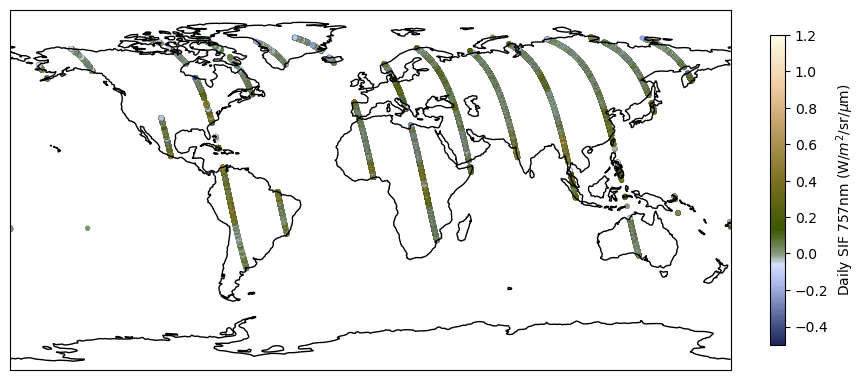

In [250]:
# Plot Daily SIF data
plt.style.use("default")
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()
s = ax.scatter(ds.lon, ds.lat, c=ds.sif,
               s=8, cmap=cm, norm=offset, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mappable=s, ax=ax, fraction=0.02, pad=0.05)
cbar.set_label("Daily SIF 757nm (W/$m^2$/sr/$\mu$m)")
# plt.savefig("../plots/sif_single_day.png");

## Read in all netcdf files

In [4]:
# Open multiple datasets across yearly subdirectories
paths = "../data/OCO2_SIF_Lite/*/*.nc4"

with xarray.open_mfdataset(paths, preprocess=preprocess, parallel=True) as ds:
    DS = ds

In [4]:
DS

<xarray.Dataset>
Dimensions:  (time: 345040399)
Coordinates:
    lon      (time) float32 -179.75006 -179.7583 ... -178.59198 -178.54816
    lat      (time) float32 -19.618774 -19.625916 ... 71.687195 71.6803
  * time     (time) datetime64[ns] 2014-09-06T01:47:00.898437504 ... 2020-07-...
Data variables:
    sif      (time) float32 -0.090768814 0.10644817 ... 0.026396751 -0.7075958

In [8]:
# Attempt to open files directly from opendap
# from pydap.client import open_url
# from pydap.cas.urs import setup_session

# url = "https://oco2.gesdisc.eosdis.nasa.gov/opendap//OCO2_L2_Lite_SIF.10r/2020/oco2_LtSIF_200731_B10206r_200810180155s.nc4"
# username = "joshhjacobson"
# password = "4c0c9t*3HA5o"

# session = setup_session(username, password, check_url=url)
# pydap_ds = open_url(url, session=session)
# store = xarray.backends.PydapDataStore(pydap_ds)
# ds = xarray.open_dataset(store)

## 16 day window

Text(0.5, 1.0, '16 day window centered on 2016-07-08')

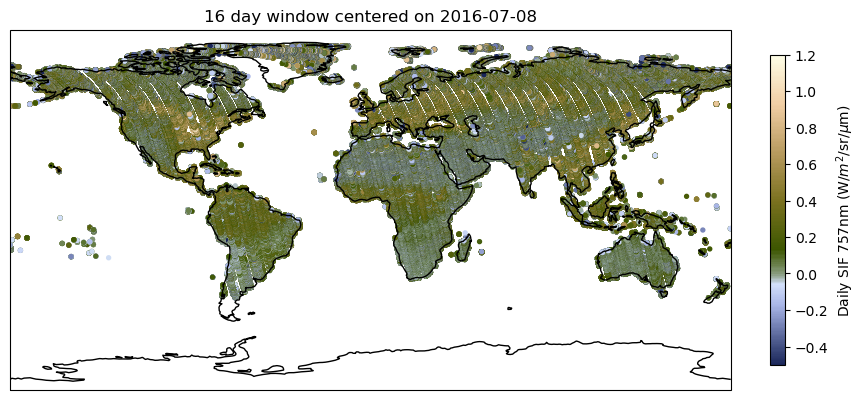

In [251]:
sif_window = DS.sel(time=slice("2016-07-01", "2016-07-16"))

plt.style.use("default")
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()
s = ax.scatter(sif_window.lon, sif_window.lat, c=sif_window.sif, 
               s=8, cmap=cm, norm=offset, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mappable=s, ax=ax, fraction=0.02, pad=0.05)
cbar.set_label("Daily SIF 757nm (W/$m^2$/sr/$\mu$m)")
plt.title("16 day window centered on 2016-07-08")
# plt.savefig("../plots/sif_16day_window.png");

## Produce monthly climatology

In [10]:
sif_clima_month = DS.sif.resample(time="1MS").mean(dim="time").to_dataframe()
sif_clima_month.head()

,sif
time,
2014-09-01,0.083272
2014-10-01,0.066533
2014-11-01,0.047827
2014-12-01,0.045286
2015-01-01,0.048568


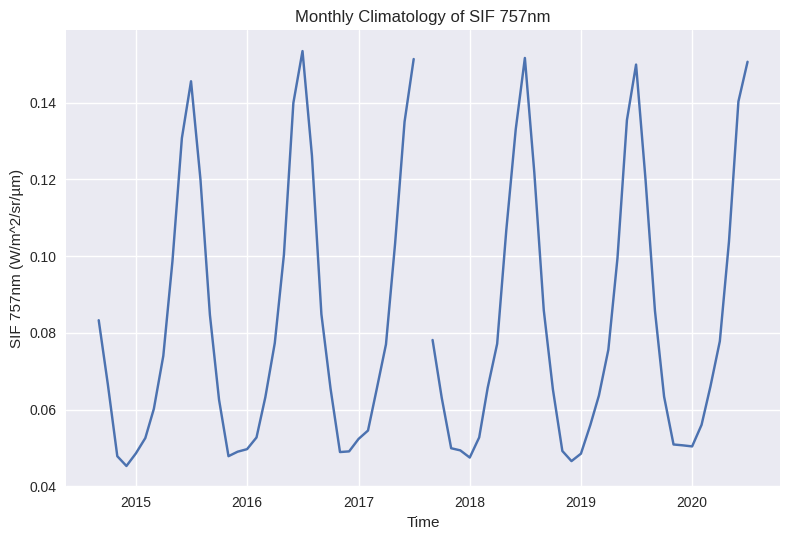

In [13]:
plt.style.use("seaborn")
# plt.figure(figsize=(8,6))
sns.lineplot(data=sif_clima_month, x="time", y="sif")
plt.xlabel("Time")
plt.ylabel("SIF 757nm [W/m$^2$/sr/$\mu$m]")
plt.title("OCO-2 SIF Lite: Monthly Climatology of SIF 757nm (Global Average)")
plt.tight_layout()
# plt.savefig("../plots/sif_monthly_climatology.png");

## Plot 1-degree bin mean for a given month

In [7]:
def aggregate_grid(ds):
    
    # Map lat-lon to 1-degree bins
    df = ds.to_dataframe()
    df["lon"] = pd.cut(df.lon, np.arange(-180, 181), labels=np.arange(-179.5, 180.5)).astype(float)
    df["lat"] = pd.cut(df.lat, np.arange(-85, 86), labels=np.arange(-84.5, 85.5)).astype(float)

    # Group by bins, compute mean, return data array
    return df.groupby(["lon", "lat"]).mean().to_xarray()

In [6]:
# Select a single month and apply aggregation function
DS_1m = DS.sel(time=slice("2016-07-01", "2016-07-30"))
ds_1m_grid = aggregate_grid(DS_1m)

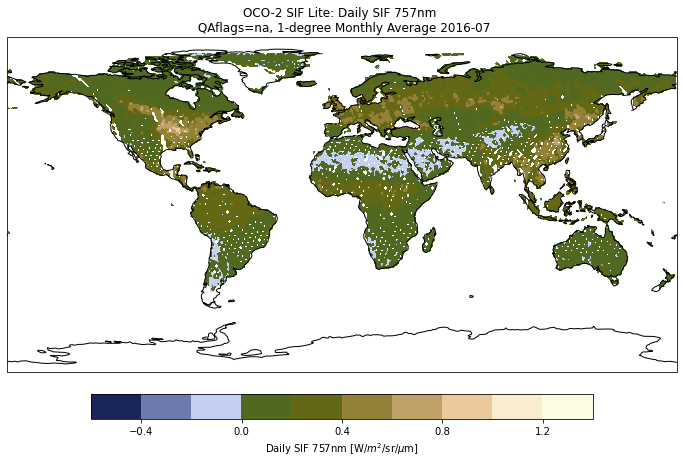

In [27]:
# plt.style.use("default")
# grid_kws = {"height_ratios": (0.9, 0.1)} , gridspec_kw=grid_kws
sub_kws = {"projection": ccrs.PlateCarree()}
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=sub_kws)
    
ax.set_global()
ax.coastlines()


contour = ax.contourf(ds_1m_grid.lon, ds_1m_grid.lat, ds_1m_grid.sif.T, levels=10,
                      cmap=cm, norm=offset, transform=ccrs.PlateCarree())

cbar = fig.colorbar(mappable=contour, ax=ax, orientation="horizontal", shrink=0.75, pad=0.05)
cbar.set_label("Daily SIF 757nm [W/$m^2$/sr/$\mu$m]")
ax.set_title(f"OCO-2 SIF Lite: Daily SIF 757nm \n \
QAflags=na, 1-degree Monthly Average {pd.to_datetime(DS_1m.time.values[0]).strftime('%Y-%m')}");

## Animate 1-degree aggregated data over months in 2016

In [10]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [41]:
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
DS_1m = DS.sel(time=slice("2016-01-01", "2016-04-30"))
DS_agg = DS_1m.resample(time="1MS").map(aggregate_grid)

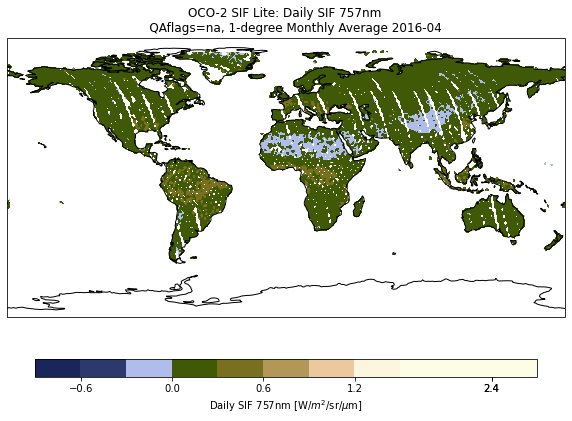

In [75]:
# Figure setup
# plt.style.use("default")
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(100,100)
ax = fig.add_subplot(gs[0:95, :], projection=ccrs.PlateCarree())
cbar_ax = fig.add_subplot(gs[95:, 5:95])

    
def animate(month):
    """Update contour with new frame (each frame should be a monthly group)"""
    da = DS_agg.sif.isel(time=month)
    
    ax.clear()
    cbar_ax.clear()
    
    ax.set_global()
    ax.coastlines()
    contour = ax.contourf(da.lon, da.lat, da.values.T, 
                          levels=10, norm=offset,
#                           vmin=-0.5, vmax=1.3,
                          cmap=cm,  transform=ccrs.PlateCarree())
    
    

    cbar = fig.colorbar(contour, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Daily SIF 757nm [W/$m^2$/sr/$\mu$m]")
    ax.set_title(f"OCO-2 SIF Lite: Daily SIF 757nm \n \
    QAflags=na, 1-degree Monthly Average {pd.to_datetime(da.time.values).strftime('%Y-%m')}")
    

mov = FuncAnimation(fig, animate, frames=DS_agg.time.size,
                    interval=1000)

HTML(mov.to_html5_video())